Exercise 9) train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

Import the data

In [12]:
import numpy as np
from sklearn.datasets import fetch_openml

digits = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
X = digits["data"]
y = digits["target"].astype(np.uint8)

Split into train and test

In [13]:
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Train the model. Amazingly, this runs faster locally on a mac than on Google's Jupyter Colab (~30s quicker)

In [14]:
import time
from sklearn.svm import LinearSVC

start_time = time.time()

svc = LinearSVC(random_state=256)
svc.fit(X_train, y_train)

end_time = time.time()
print("Training Complete. Time Elapsed: %f seconds" % (end_time - start_time))

Training Complete. Time Elapsed: 141.671842 seconds


/Users/alexkatopodis/Desktop/coding/python/Duke/HOML/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
from sklearn.metrics import accuracy_score

y_pred = svc.predict(X_train)
accuracy_score(y_train, y_pred)

0.8847333333333334

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [17]:
start_time = time.time()

svc_scaled = LinearSVC(random_state=256)
svc_scaled.fit(X_train_scaled, y_train)

end_time = time.time()
print("Training Complete. Time Elapsed: %f seconds" % (end_time - start_time))

Training Complete. Time Elapsed: 3466.595742 seconds


/Users/alexkatopodis/Desktop/coding/python/Duke/HOML/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [18]:
y_pred_scaled = svc_scaled.predict(X_train_scaled)
accuracy_score(y_train, y_pred_scaled)

0.9226166666666666

In [22]:
from sklearn.svm import SVC

start_time = time.time()

svm_clf = SVC(kernel="rbf", gamma="scale", random_state=256)  # RBF is default
svm_clf.fit(X_train_scaled, y_train)

end_time = time.time()
print("Training Complete. Time Elapsed: %f seconds" % (end_time - start_time))

Training Complete. Time Elapsed: 345.030592 seconds


Scaling the data has a huge impact on model performance with Support Vector Machines

In [20]:
y_pred_rbf = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred_rbf)

0.9866333333333334

Run RandomizedSearch Cross Validation on tiny training sets to try and find the best hyperparameters. Ultimately we will retrain the best model on the whole training set.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=9.27012272418138, gamma=0.004033627106517338; total time=   0.2s
[CV] END .....C=9.27012272418138, gamma=0.004033627106517338; total time=   0.2s
[CV] END .....C=9.27012272418138, gamma=0.004033627106517338; total time=   0.2s
[CV] END ....C=7.364296850006623, gamma=0.043835218195682785; total time=   0.2s
[CV] END ....C=7.364296850006623, gamma=0.043835218195682785; total time=   0.2s
[CV] END ....C=7.364296850006623, gamma=0.043835218195682785; total time=   0.2s
[CV] END ....C=7.162136873021988, gamma=0.018373071368384876; total time=   0.2s
[CV] END ....C=7.162136873021988, gamma=0.018373071368384876; total time=   0.2s
[CV] END ....C=7.162136873021988, gamma=0.018373071368384876; total time=   0.2s
[CV] END ...C=4.606656568830608, gamma=0.0012502209375756168; total time=   0.2s
[CV] END ...C=4.606656568830608, gamma=0.0012502209375756168; total time=   0.2s
[CV] END ...C=4.606656568830608, gamma=0.0012502

RandomizedSearchCV(cv=3, estimator=SVC(random_state=256),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13d9d4fd0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1397c1ac0>},
                   verbose=2)

In [24]:
start_time = time.time()

rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

end_time = time.time()
print("Training Complete. Time Elapsed: %f seconds" % (end_time - start_time))

Training Complete. Time Elapsed: 339.421049 seconds


In [25]:
y_pred_final_train = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred_final_train)

0.9967833333333334

In [27]:
y_pred_final_test = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred_final_test)

0.9729

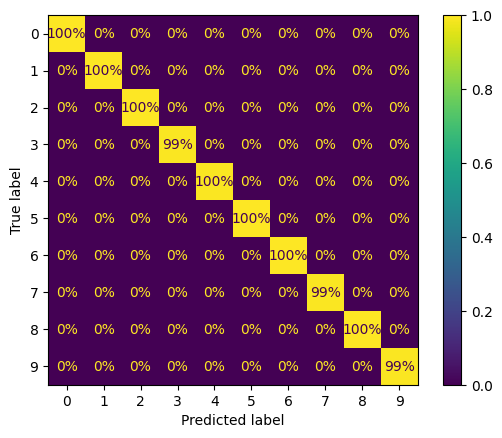

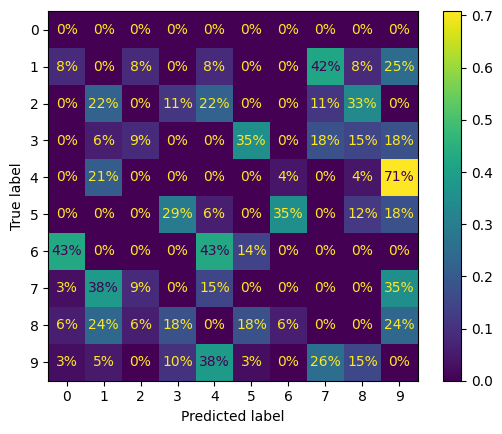

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_final_train,
                                        normalize="true", values_format=".0%")
plt.show()

sample_weight = (y_pred_final_train != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_final_train,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()